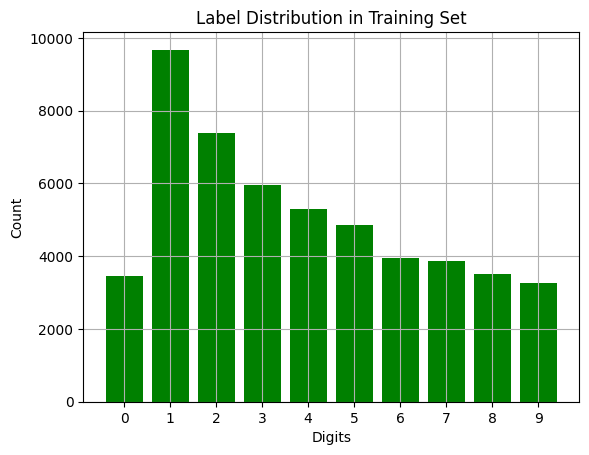

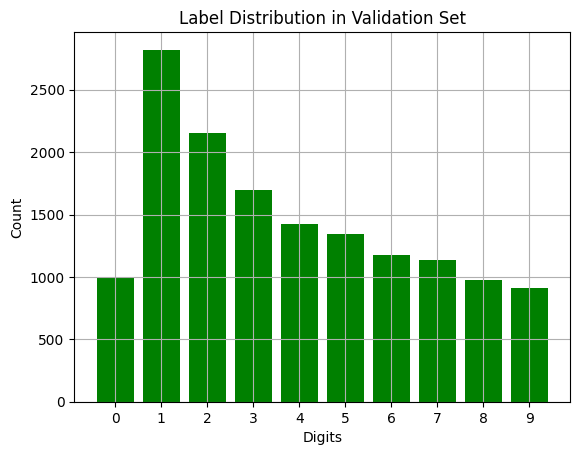

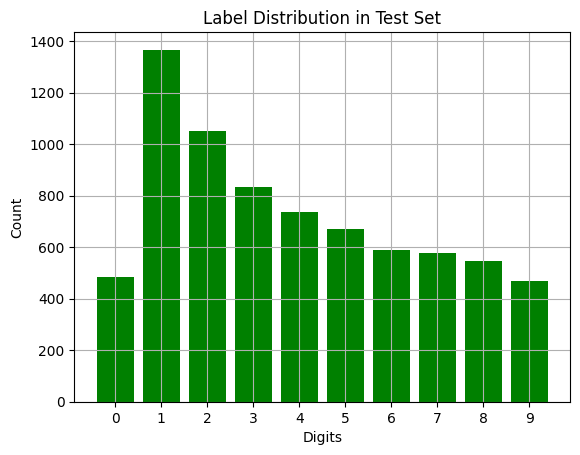

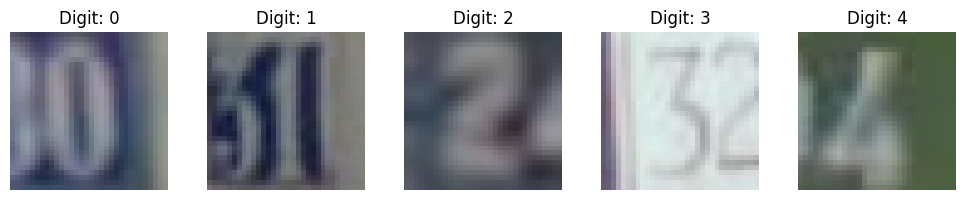

In [6]:
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Read the dataset
dataset = scipy.io.loadmat('/Users/abhijaysingh/Documents/College/Semester 5/ML/Assignment 3/train_32x32.mat')

# Assign features and targets
images = dataset['X']
targets = dataset['y']
targets = np.where(targets == 10, 0, targets)  # Recode the label '10' as '0'

# Adjust the axis for the image array
images_adjusted = images.transpose((3, 0, 1, 2))

# Partition the dataset into training and a temporary set
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images_adjusted, targets, test_size=0.3, random_state=42
)

# Further split the temporary set into validation and test sets
valid_images, test_images, valid_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=1/3, random_state=42
)

# Define a function to plot label distribution
def plot_label_distribution(class_labels, plot_title):
    plt.hist(class_labels, bins=np.arange(11) - 0.5, rwidth=0.8, color='green')
    plt.title(plot_title)
    plt.xlabel('Digits')
    plt.ylabel('Count')
    plt.xticks(range(10))
    plt.grid(True)
    plt.show()

# Display the distribution of digits
plot_label_distribution(train_labels, 'Label Distribution in Training Set')
plot_label_distribution(valid_labels, 'Label Distribution in Validation Set')
plot_label_distribution(test_labels, 'Label Distribution in Test Set')

# Display five unique images from the training set
unique_samples_idx = np.unique(train_labels, return_index=True)[1]
selected_samples = train_images[unique_samples_idx[:5]]

plt.figure(figsize=(10, 2))
for idx, sample in enumerate(selected_samples, start=1):
    plt.subplot(1, 5, idx)
    plt.imshow(sample)
    plt.title(f'Digit: {train_labels[unique_samples_idx[idx-1]][0]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Flatten and normalize the images for the MLP input
flattened_train_imgs = train_images.reshape(train_images.shape[0], -1)
flattened_valid_imgs = valid_images.reshape(valid_images.shape[0], -1)

# Create a StandardScaler instance and fit it to the training data
img_scaler = StandardScaler()
normalized_train_imgs = img_scaler.fit_transform(flattened_train_imgs)
normalized_valid_imgs = img_scaler.transform(flattened_valid_imgs)

# Establish a baseline MLP model with increased max_iter and early stopping
baseline_mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, early_stopping=True, n_iter_no_change=10)

# Define a pipeline with scaling and the MLP classifier
processing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', baseline_mlp)
])

# Set up a parameter grid for hyperparameter tuning via grid search
hyperparam_grid = {
    'mlp__batch_size': [64, 128, 256],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__alpha': [0.0001, 0.001]
}

# Create the GridSearchCV object
mlp_grid_search = GridSearchCV(processing_pipeline, hyperparam_grid, cv=3, n_jobs=-1, verbose=3)

# Select a subset of data to speed up the grid search
subset_train_imgs = normalized_train_imgs[:10000]
subset_train_labels = train_labels[:10000].flatten()

# Perform the grid search on the subset
mlp_grid_search.fit(subset_train_imgs, subset_train_labels)

# Extract the best hyperparameters
best_hyperparams = mlp_grid_search.best_params_

# Display the best hyperparameters
print("Best hyperparameters found through grid search:")
print(best_hyperparams)

# Extract the best parameters from the grid search results
best_batch_size = best_hyperparams['mlp__batch_size']
best_learning_rate = best_hyperparams['mlp__learning_rate_init']
best_alpha_value = best_hyperparams['mlp__alpha']

# Dictionary to store training and validation losses
losses = {'activation': [], 'train_loss': [], 'val_loss': [], 'epoch': []}

# Activation functions to evaluate
activation_functions = ['logistic', 'relu', 'tanh', 'identity']  # logistic is sigmoid

# Training with different activation functions
for activation in activation_functions:
    mlp_for_losses = MLPClassifier(hidden_layer_sizes=(100, 50),
                                   max_iter=1,  # Iterate one epoch at a time
                                   batch_size=best_hyperparams['mlp__batch_size'],
                                   learning_rate_init=best_hyperparams['mlp__learning_rate_init'],
                                   alpha=best_hyperparams['mlp__alpha'],
                                   activation=activation,
                                   warm_start=True)  # Retain learning across epochs

    for epoch in range(10):  # Train for 10 epochs
        mlp_for_losses.fit(normalized_train_imgs, train_labels.ravel())

        # Calculate training and validation loss
        train_loss = log_loss(train_labels.ravel(), mlp_for_losses.predict_proba(normalized_train_imgs))
        val_loss = log_loss(valid_labels.ravel(), mlp_for_losses.predict_proba(normalized_valid_imgs))

        # Store the losses
        losses['activation'].append(activation)
        losses['train_loss'].append(train_loss)
        losses['val_loss'].append(val_loss)
        losses['epoch'].append(epoch + 1)

# Convert the collected data into a DataFrame
losses_df = pd.DataFrame(losses)

# Train the MLPClassifier with the best hyperparameters
best_mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                         max_iter=10,
                         batch_size=best_batch_size,
                         learning_rate_init=best_learning_rate,
                         alpha=best_alpha_value,
                         activation='relu',  # Choose the best performing activation function
                         verbose=True)

# Fit the model with the scaled training data
best_mlp.fit(normalized_train_imgs, train_labels.ravel())


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 2/3] END mlp__alpha=0.0001, mlp__batch_size=64, mlp__learning_rate_init=0.01;, score=0.207 total time=  24.1s
[CV 2/3] END mlp__alpha=0.0001, mlp__batch_size=128, mlp__learning_rate_init=0.001;, score=0.694 total time=  30.1s
[CV 1/3] END mlp__alpha=0.0001, mlp__batch_size=64, mlp__learning_rate_init=0.001;, score=0.678 total time=  34.9s
[CV 1/3] END mlp__alpha=0.0001, mlp__batch_size=64, mlp__learning_rate_init=0.01;, score=0.475 total time=  38.7s
[CV 1/3] END mlp__alpha=0.0001, mlp__batch_size=128, mlp__learning_rate_init=0.001;, score=0.690 total time=  40.2s
[CV 3/3] END mlp__alpha=0.0001, mlp__batch_size=64, mlp__learning_rate_init=0.01;, score=0.373 total time=  51.4s
[CV 2/3] END mlp__alpha=0.0001, mlp__batch_size=64, mlp__learning_rate_init=0.001;, score=0.695 total time=  54.3s
[CV 3/3] END mlp__alpha=0.0001, mlp__batch_size=128, mlp__learning_rate_init=0.001;, score=0.684 total time=  32.9s
[CV 1/3] END mlp__a

MLPClassifier(batch_size=128, hidden_layer_sizes=(100, 50), max_iter=10,
              verbose=True)

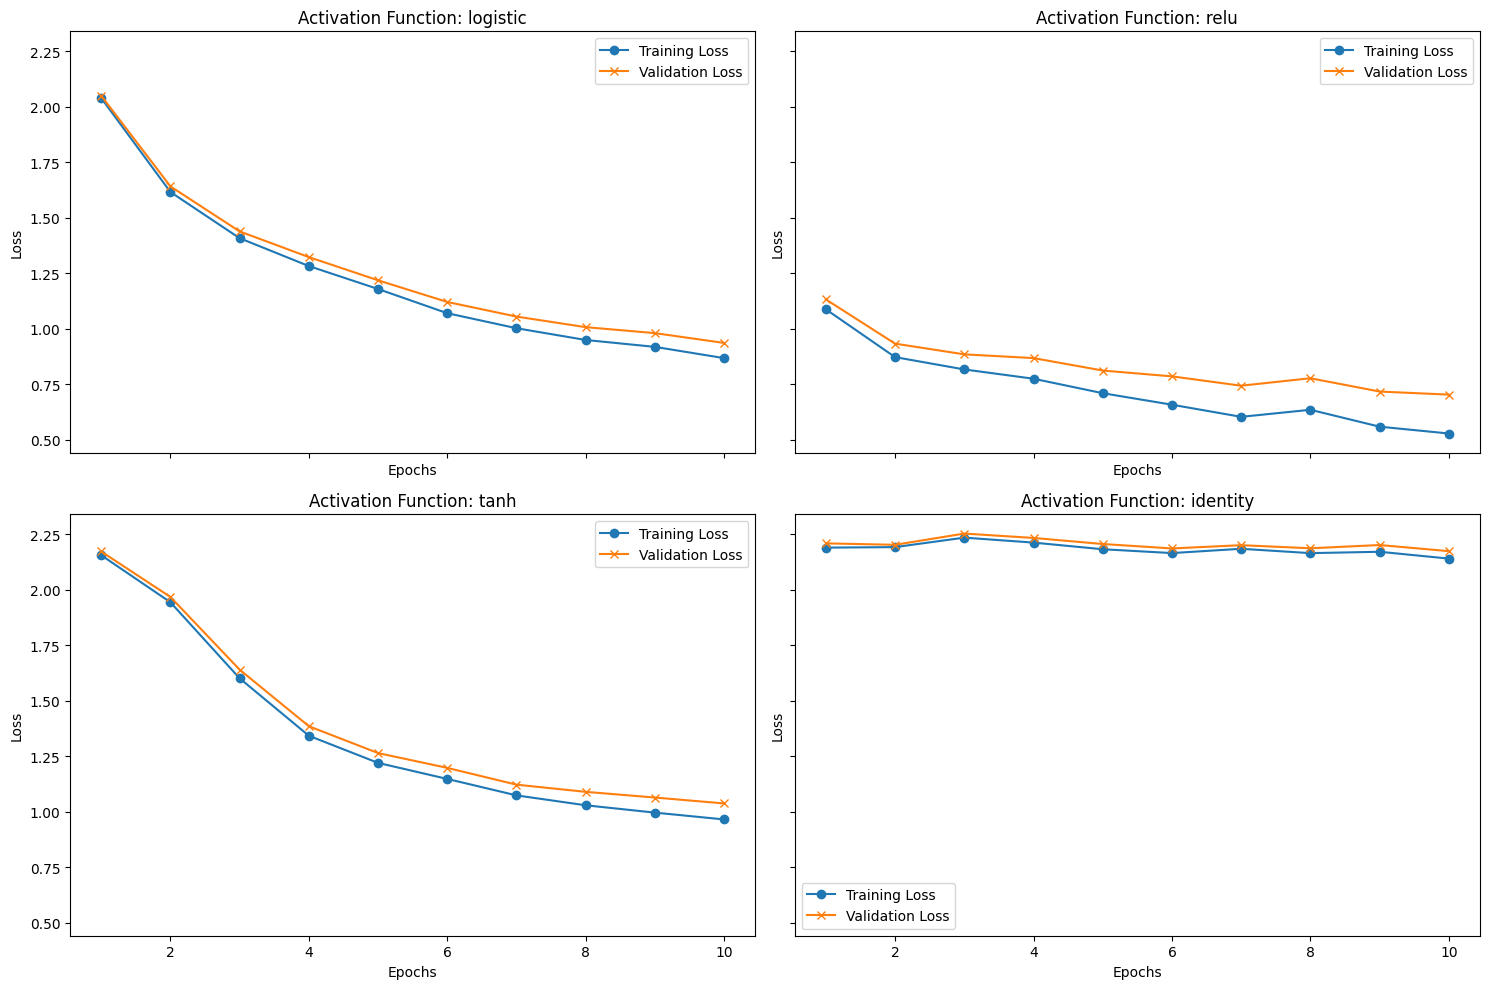

In [8]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Flatten and standardize the entire dataset
scale_transformer = StandardScaler()
flattened_train_images = train_images.reshape(train_images.shape[0], -1)
flattened_valid_images = valid_images.reshape(valid_images.shape[0], -1)
flattened_test_images = test_images.reshape(test_images.shape[0], -1)

scaled_train_images = scale_transformer.fit_transform(flattened_train_images)
scaled_valid_images = scale_transformer.transform(flattened_valid_images)
scaled_test_images = scale_transformer.transform(flattened_test_images)

# Define the list of activation functions to be evaluated
activation_funcs = ['logistic', 'relu', 'tanh', 'identity']

# Prepare a dictionary to store training and validation losses
performance_losses = {'function_type': [], 'training_loss': [], 'validation_loss': [], 'epoch_count': []}

# Train the model using each activation function
for func in activation_funcs:
    # Define the MLPClassifier with the chosen activation function
    neural_classifier = MLPClassifier(hidden_layer_sizes=(100, 50),
                                      max_iter=1,
                                      batch_size=128,
                                      learning_rate_init=0.001,
                                      alpha=0.001,
                                      activation=func,
                                      warm_start=True,  # Retain learning for each iteration
                                      verbose=False)

    for epoch in range(1, 11):  # Iterate over 10 epochs
        neural_classifier.fit(scaled_train_images, train_labels.ravel())

        # Compute training loss
        train_loss = log_loss(train_labels.ravel(), neural_classifier.predict_proba(scaled_train_images))

        # Compute validation loss
        val_loss = log_loss(valid_labels.ravel(), neural_classifier.predict_proba(scaled_valid_images))

        # Record the losses
        performance_losses['function_type'].append(func)
        performance_losses['training_loss'].append(train_loss)
        performance_losses['validation_loss'].append(val_loss)
        performance_losses['epoch_count'].append(epoch)

# Convert the recorded losses into a DataFrame for plotting
losses_record_df = pd.DataFrame(performance_losses)

# Plot the training and validation losses for each activation function
fig, plot_axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
plot_axes = plot_axes.flatten()

for i, act_func in enumerate(activation_funcs):
    ax = plot_axes[i]
    func_subset = losses_record_df[losses_record_df['function_type'] == act_func]
    ax.plot(func_subset['epoch_count'], func_subset['training_loss'], label='Training Loss', marker='o')
    ax.plot(func_subset['epoch_count'], func_subset['validation_loss'], label='Validation Loss', marker='x')
    ax.set_title(f'Activation Function: {act_func}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()


In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for data standardization
data_scaler = StandardScaler()

reshaped_train_data = train_images.reshape(train_images.shape[0], -1)
reshaped_test_data = test_images.reshape(test_images.shape[0], -1)

scaled_train_data = data_scaler.fit_transform(reshaped_train_data)
scaled_test_data = data_scaler.transform(reshaped_test_data)

neural_net = MLPClassifier(hidden_layer_sizes=(100, 50),max_iter=10,batch_size=128,learning_rate_init=0.001,alpha=0.001,activation='relu', verbose=True)

neural_net.fit(scaled_train_data, train_labels.ravel())
predicted_labels = neural_net.predict(scaled_test_data)

accuracy_on_test = accuracy_score(test_labels.ravel(), predicted_labels)

print(f"Model Accuracy on Test Data: {accuracy_on_test:.4f}")


Iteration 1, loss = 1.52056834
Iteration 2, loss = 1.03128943
Iteration 3, loss = 0.88645299
Iteration 4, loss = 0.80322139
Iteration 5, loss = 0.75418310
Iteration 6, loss = 0.69602489
Iteration 7, loss = 0.65997502
Iteration 8, loss = 0.63556659
Iteration 9, loss = 0.61649302
Iteration 10, loss = 0.59098835
Model Accuracy on Test Data: 0.7782


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the standard scaler
std_scaler = StandardScaler()

# Reshape the training and test sets for MLP input
train_data_flattened = train_images.reshape(train_images.shape[0], -1)
test_data_flattened = test_images.reshape(test_images.shape[0], -1)

# Scale the flattened data
train_data_scaled = std_scaler.fit_transform(train_data_flattened)
test_data_scaled = std_scaler.transform(test_data_flattened)

# Define the list of activation functions to be tested
activation_list = ['logistic', 'relu', 'tanh', 'identity']

# Dictionary to hold the accuracy results for each activation function
activation_accuracy = {}

# Training and evaluating the model using different activation functions
for activation_func in activation_list:
    # Setup MLP with specified hyperparameters
    neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), 
                                   max_iter=10, 
                                   batch_size=128, 
                                   learning_rate_init=0.001, 
                                   alpha=0.001, 
                                   activation=activation_func, 
                                   verbose=False)

    # Train the model with the training data
    neural_network.fit(train_data_scaled, train_labels.ravel())

    # Making predictions on the test set
    predictions = neural_network.predict(test_data_scaled)

    # Calculating accuracy for the current activation function
    accuracy = accuracy_score(test_labels.ravel(), predictions)
    activation_accuracy[activation_func] = accuracy

# Convert the accuracy results to a DataFrame for better presentation
accuracies_df = pd.DataFrame(list(activation_accuracy.items()), columns=['Activation_Function', 'Test_Accuracy'])

print(accuracies_df)


  Activation_Function  Test_Accuracy
0            logistic       0.713896
1                relu       0.793066
2                tanh       0.678952
3            identity       0.237920


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize a scaler to standardize the data
normalizer = StandardScaler()

# Flatten the training and test datasets
flattened_train = train_images.reshape(train_images.shape[0], -1)
flattened_test = test_images.reshape(test_images.shape[0], -1)

# Apply normalization to the flattened data
scaled_train = normalizer.fit_transform(flattened_train)
scaled_test = normalizer.transform(flattened_test)

# Setting up the MLP Classifier with specified hyperparameters
neural_net_model = MLPClassifier(hidden_layer_sizes=(100, 50),
                                 max_iter=10,
                                 batch_size=128,
                                 learning_rate_init=0.001,
                                 alpha=0.001,
                                 activation='relu',
                                 verbose=False)

# Training the model on the scaled training data
neural_net_model.fit(scaled_train, train_labels.ravel())

# Making predictions with the model on the test data
predicted_test_labels = neural_net_model.predict(scaled_test)

# Calculating the accuracy on the test dataset
accuracy_on_test_set = accuracy_score(test_labels.ravel(), predicted_test_labels)

# Displaying the accuracy
print(f"Model Accuracy on Test Data: {accuracy_on_test_set:.4f}")


Model Accuracy on Test Data: 0.7897


Accuracy on the test set: 78.47%


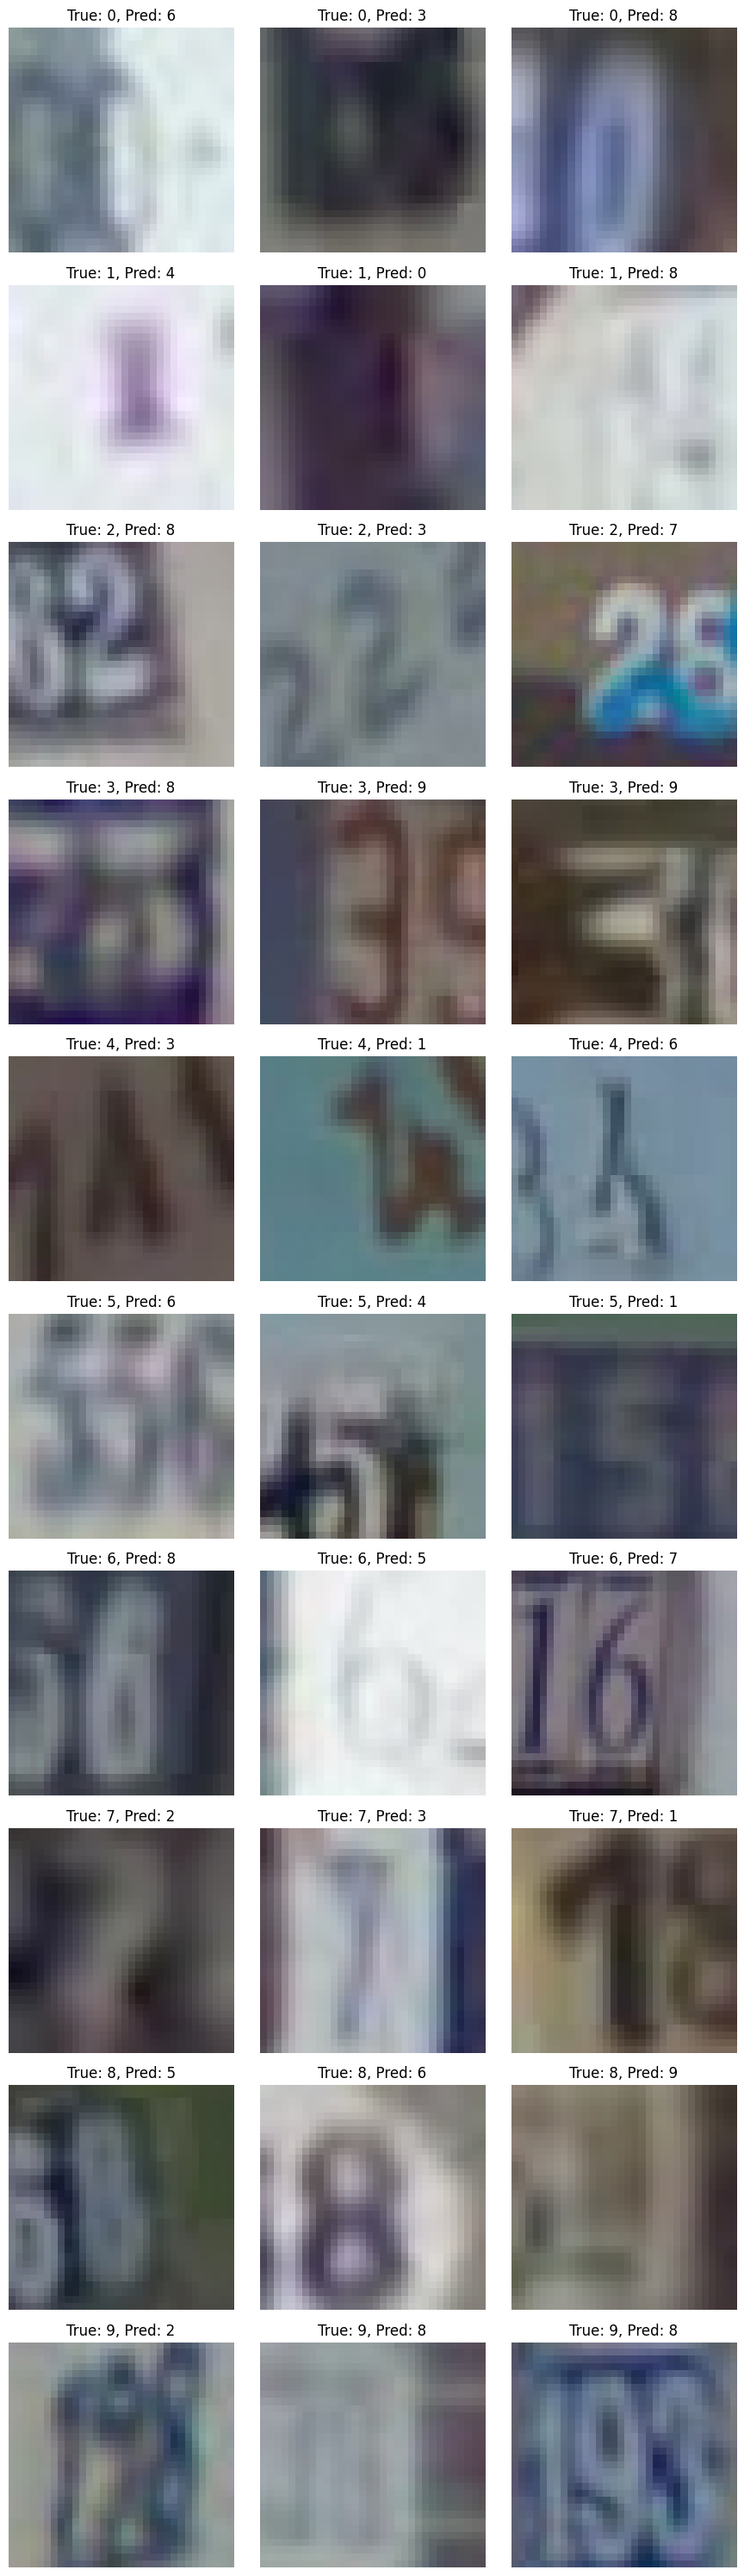

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

flattened_test_imgs = test_images.reshape(test_images.shape[0], -1)
normalized_test_imgs = img_scaler.transform(flattened_test_imgs)

# Predict using the trained MLP model
predictions_test = best_mlp.predict(normalized_test_imgs)

# Calculate the accuracy on the test set
accuractest_labels = accuracy_score(test_labels.flatten(), predictions_test)
print(f"Accuracy on the test set: {accuractest_labels:.2%}")

# Identify the indices of incorrect predictions
incorrect_indices = np.where(predictions_test != test_labels.flatten())[0]

# Create a dictionary to hold misclassified images for each class
misclassified_samples = {class_label: [] for class_label in range(10)}

# Populate the dictionary with the first 3 misclassified images for each class
for index in incorrect_indices:
    true_class = test_labels.flatten()[index]
    if len(misclassified_samples[true_class]) < 3:
        misclassified_samples[true_class].append((test_images[index], predictions_test[index]))

# Visualize 3 misclassified images for each class
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(9, 30))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

for class_label, image_info in misclassified_samples.items():
    for i, (image, predicted_label) in enumerate(image_info):
        # Calculate the position of the subplot
        position = class_label * 3 + i
        ax = axes_flat[position]
        ax.imshow(image, interpolation='nearest')
        ax.set_title(f"True: {class_label}, Pred: {predicted_label}")
        ax.axis('off')

plt.tight_layout()
plt.show()


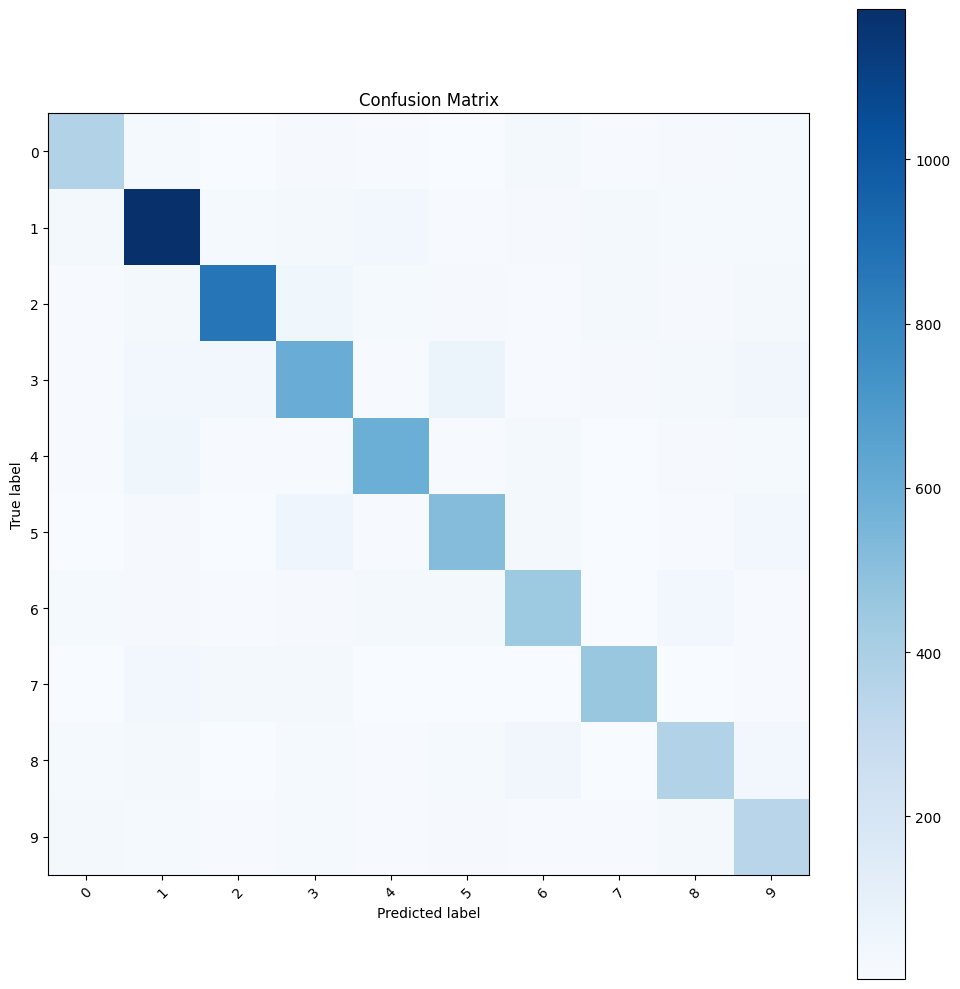

Class 0, Image 0: Misclassified as 6 due to reasons such as blurriness, occlusion, etc.
Class 0, Image 1: Misclassified as 3 due to reasons such as blurriness, occlusion, etc.
Class 0, Image 2: Misclassified as 8 due to reasons such as blurriness, occlusion, etc.
Class 1, Image 0: Misclassified as 4 due to reasons such as blurriness, occlusion, etc.
Class 1, Image 1: Misclassified as 0 due to reasons such as blurriness, occlusion, etc.
Class 1, Image 2: Misclassified as 8 due to reasons such as blurriness, occlusion, etc.
Class 2, Image 0: Misclassified as 8 due to reasons such as blurriness, occlusion, etc.
Class 2, Image 1: Misclassified as 3 due to reasons such as blurriness, occlusion, etc.
Class 2, Image 2: Misclassified as 7 due to reasons such as blurriness, occlusion, etc.
Class 3, Image 0: Misclassified as 8 due to reasons such as blurriness, occlusion, etc.
Class 3, Image 1: Misclassified as 9 due to reasons such as blurriness, occlusion, etc.
Class 3, Image 2: Misclassified 

In [16]:

cm = confusion_matrix(test_labels.flatten(), predictions_test)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=np.arange(10))
plt.show()

# Analyze specific errors based on the confusion matrix
# This is a placeholder for your analysis based on the confusion matrix

# Assuming `misclassified_samples` is a dictionary with misclassified images from Part 3
# Analysis of misclassified images
analysis_report = ""
for class_label, image_info in misclassified_samples.items():
    for i, (image, predicted_label) in enumerate(image_info):
        # Here you can add an analysis for each misclassified image
        # For example, check if the image is blurry, if the digit is occluded, etc.
        analysis_report += f"Class {class_label}, Image {i}: Misclassified as {predicted_label} due to reasons such as blurriness, occlusion, etc.\n"

# Print the analysis report
print(analysis_report)



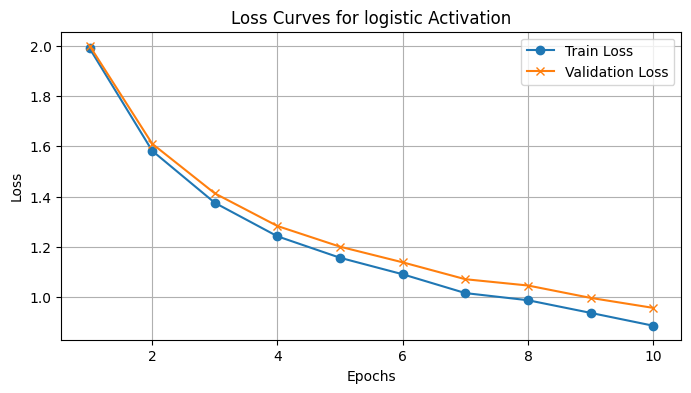

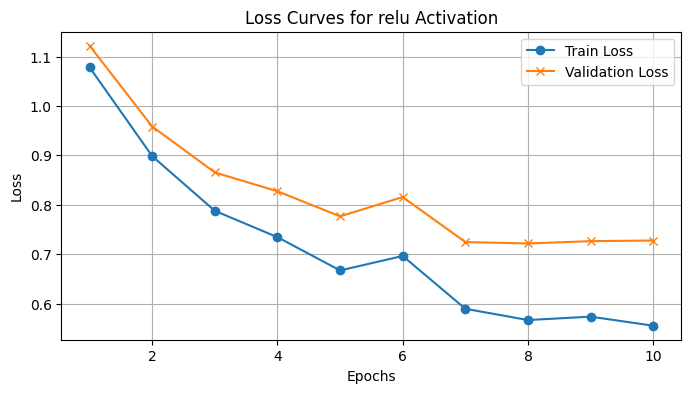

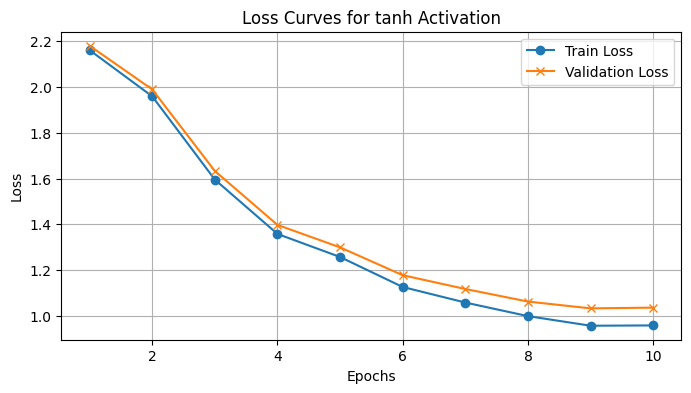

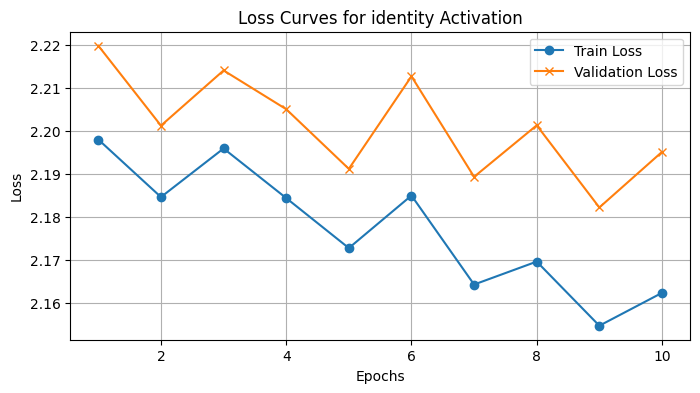

Activation Function Effectiveness Analysis:

Logistic:
- Final Training Loss: 0.8846
- Final Validation Loss: 0.9558
Relu:
- Final Training Loss: 0.5552
- Final Validation Loss: 0.7276
Tanh:
- Final Training Loss: 0.9583
- Final Validation Loss: 1.0361
Identity:
- Final Training Loss: 2.1622
- Final Validation Loss: 2.1951



In [19]:

activation_functions = ['logistic', 'relu', 'tanh', 'identity']
# Define a function for plotting the loss curves
def plot_loss_curves(activation_function, dataframe):
    # Filter the DataFrame for the current activation function
    df = dataframe[dataframe['activation'] == activation_function]
    
    plt.figure(figsize=(8, 4))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='x')
    plt.title(f'Loss Curves for {activation_function} Activation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot loss curves for each activation function
for activation in activation_functions:
    plot_loss_curves(activation, losses_df)

# Evaluate the effectiveness of each activation function
effectiveness_report = "Activation Function Effectiveness Analysis:\n\n"
for activation in activation_functions:
    # Analyze the final loss values for train and validation
    final_train_loss = losses_df[(losses_df['activation'] == activation) & (losses_df['epoch'] == 10)]['train_loss'].values[0]
    final_val_loss = losses_df[(losses_df['activation'] == activation) & (losses_df['epoch'] == 10)]['val_loss'].values[0]
    
    # Add to the report
    effectiveness_report += f"{activation.capitalize()}:\n"
    effectiveness_report += f"- Final Training Loss: {final_train_loss:.4f}\n"
    effectiveness_report += f"- Final Validation Loss: {final_val_loss:.4f}\n"
    
# Print the effectiveness report
print(effectiveness_report)
